# Computational Methods in Economics

## Lecture 4 - Root Finding

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2019-12-05 19:01:57.602971


## Preliminaries

#### Import Modules

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as display

## This Lecture

- [Introduction](#introduction)
- [Bisection](#bisection)
- [Newton's Method](#newton)
- [Numerical Differentiation](#numdiff)
- [Quasi-Newton Methods](#quasi)
- [Convergence](#convergence)
- [The Scipy Package](#scipy)
- [Appendix: Function Iteration](#funiter)
- [Appendix: Backstepping](#back)

--------------------------------------------------------------------------------------------------------------------------------
<a id = "introduction"></a>

## Introduction

A function $f(x)$ has a *root* (also called a *zero*) at $x^*$ if $f(x^*) = 0$. Two cases are relevant:

- $f$ can be a univariate scalar/real-valued function $f: \mathbb{R}\ \rightarrow \mathbb{R}$, i.e. both input and output are scalars, or both its range and its domain have a dimension of 1


- $f$ can be a vector-valued function $\mathbf{f}: \mathbb{R}^n\ \rightarrow \mathbb{R}^n$, i.e. both its range and its domain have a dimension greater than 1. In this case, finding the roots of a vector-valued function is equivalent to *solving a system of nonlinear equations*. 

The intermediate case of a multivariate scalar function $f: \mathbb{R}^n\ \rightarrow \mathbb{R}$ - its inputs are vectors, hence its domain has a dimension greater than 1 - is going to be important in the next lecture. 

Finding the root(s) of a function is one of the most common computational problems in economics, often applied when looking for an equilibrium. In other words, an equilibrium is usually defined by a set of equations, as illustrated by the following example.


#### Example: Neoclassical Growth Model

Recall the standard NGM that you have seen in Macro:

- Utility function:

\begin{equation}
    u(c, h) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h^{1+\eta}}{1+\eta}
\end{equation}

with $c$ denoting consumption and $h$ labor supply.

- Production function:

\begin{equation}
    f(k, h) = A k^\alpha h^{1-\alpha}
\end{equation}

with $k$ denoting the capital stock, and $A$ the productivity level.

- Resource Constraint:

\begin{equation}
    k_{t+1} + c_t = f(k_t, h_t) + (1 - \delta) k_t = A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t
\end{equation}

- Planner's Problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}

s.t. the resource constraint.

##### First-order conditions

(1) Euler equation

\begin{equation}
    c^{-\nu} = \beta \left[ (c')^{-\nu} (f_k(k', h') + 1 - \delta) \right]    
\end{equation}

(2) intratemporal optimality condition

\begin{equation}
    B h^{\eta} = c^{-\nu} f_h(k, h)  
\end{equation}

where I have used the notation $c = c_t$ and $c' = c_{t+1}$ (and analogous for $k$ and $h$) for brevity. 

##### Steady State

In an equilibrium, the two first-order conditions, combined with the resource constraint, must hold in every period. We will get to how to solve for the full dynamic allocation later in this course. 

For now, let's consider the *steady state*, where all variables are constant over time, i.e. $c_t = c_{t+1} = c_s$ and so on. 

The Euler equation then can be simplied to:

\begin{equation}
    1 = \beta \left[f_k(k_s, h_s) + 1 - \delta \right]    
\end{equation}

For the intratemporal optimality condition, use the resource constraint to substitute for consumption:

\begin{equation}
    B h_s^{\eta} = \left[ f(k_s, h_s) - \delta k_s \right]^{-\nu} f_h(k_s, h_s)  
\end{equation}


This is a nonlinear system of two equations, with two unknown variables, $k_s$ and $h_s$, which can be solved using the methods introduced below. We can define a vector-valued function $\mathbf{S}$ with

\begin{equation}
   \mathbf{S}(k, h) = 
    \left[
    \begin{array}{c}
        \beta \left[f_k(k, h) + 1 - \delta \right]  - 1 \\
        \left[ f(k, h) - \delta k \right]^{-\nu} f_h(k, h) - B h^{\eta}
    \end{array}
    \right]
\end{equation}

Finding the steady state of the model then requires finding a root of function $\mathbf{S}$, i.e. a vector $(k_s, h_s)$ such that 

\begin{equation}
   \mathbf{S}(k_s, h_s) = 
    \left[
    \begin{array}{c}
        0 \\
        0
    \end{array}
    \right]
\end{equation}

#### Some Preliminaries

- For a multivariate real-valued function $f: \mathbb{R}^n\ \rightarrow \mathbb{R}$, the vector consisting of the first derivatives is called the *gradient* (vector):

\begin{equation}
 \nabla f(\mathbf{x}) = \left[
\begin{matrix}
 \partial f/ \partial x_1 \\
 \vdots \\
  \partial f/ \partial x_n 
\end{matrix}  \right]
\end{equation}

where $\mathbf{x}$ is an n-by-1 vector

- For a vector-valued function $\mathbf{f}: \mathbb{R}^n\ \rightarrow \mathbb{R}^n$, the *Jacobian* (i.e., the matrix of the first derivatives), is defined as 

\begin{equation}
 J(\mathbf{x}) = \left[
\begin{matrix}
 \partial f_1/ \partial x_1 & ... & \partial f_1/ \partial x_n \\
 \vdots & \ddots & \vdots \\
  \partial f_n/ \partial x_1 & ... & \partial f_n/ \partial x_n 
\end{matrix}  \right]
\end{equation}

Using the gradient notation, we can also write this as

\begin{equation}
 J(\mathbf{x}) = \left[
\begin{matrix}
  \nabla f_1(\mathbf{x})^T \\
 \vdots  \\
  \nabla f_n(\mathbf{x})^T
\end{matrix}  \right]
\end{equation}


#### Taylor Series and Taylor's Formula

For a univariate function $f$ that is $n$ times continuously differentiable, a *Taylor series* or *Taylor approximation* around $x_0$ is given by:

\begin{equation}
    f(x) \approx f(x_0) + f'(x_0) (x - x_0) + \frac{1}{2} f''(x_0) (x - x_0)^2 + ... + \frac{1}{n!} f^{(n)}(x_0) (x - x_0)^n 
\end{equation}

Closely related to this is *Taylor's Theorem*: if $f$ is, for example, twice continuously differentiable in an interval that contains $x$ and $x_0$, then 

\begin{equation}
    f(x) = f(x_0) + f'(x_0) (x - x_0) + \frac{1}{2} f''(c) (x - x_0)^2 
\end{equation}

for some number $c$ between $x$ and $x_0$.

For a multivariate function $f: \mathbb{R}^n\ \rightarrow \mathbb{R}$, we can state Taylor's Theorem in the following way: if $f$ is twice continuously differentiable and $p \in \mathbb{R}^n$, we have that

\begin{equation}
    f(\mathbf{x}_0 + \mathbf{p}) = f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^{T} \mathbf{p} + \frac{1}{2} \mathbf{p}^T \nabla^2 f(\mathbf{x}_0 + t\mathbf{p}) \mathbf{p} 
\end{equation}

for some $t \in (0,1)$.

Below, we will need a measure for the distance of a vector to zero (i.e. its length). Recall that for a vector $\mathbf{v} \in \mathbb{R}^n$, the *Euclidean* norm is defined as 

\begin{equation}
     \left| \left|\ \mathbf{v}\ \right| \right|_2 = \left| \left|\ \mathbf{v}\ \right| \right| = \sqrt{ \sum_{j = 1}^n v_i^2} = \sqrt{ \mathbf{v}^T \mathbf{v} }
\end{equation}

In Numpy, the Euclidean norm is implemented in the **np.linalg.norm** function.

In [3]:
x = np.array([3, 4])
print(np.linalg.norm(x))

5.0


For matrices, the equivalent of the Euclidean norm is the *Frobenius* norm. For a matrix A, it is defined as

$$
    || A ||_F = \sqrt{ \sum_{i = 1}^m \sum_{j = 1}^n (a_{ij})^2 }  
$$

It can be shown that $ || A B ||_F \le ||A||_F || B ||_F $. The Frobenius norm is the default option when applying **np.linalg.norm** to matrix.

In [4]:
A = np.array([[2, 2],
              [2, 2]])
print(np.linalg.norm(A))

4.0


--------------------------------------------------------------------------------------------------------------------------------
<a id = 'bisection'></a>

## Bisection

The simplest way to compute the root of a continuous univariate real-valued function is the *bisection method*. While simple, bisection captures two important features of most root-finding and optimization methods: it is a *local* method and it is based on an *iterative procedure*.

The key idea behind the bisection method is based on the *Intermediate Value Theorem*: if $f$ is continuous and defined on the interval $[a,b]$, and if $f(a)$ and $f(b)$ are distinct values, then $f$ must assume all values in between. 

Since we are interested in where $f$ assumes the value 0, we need $f(a)$ and $f(b)$ to have *different signs*.

In [5]:
## cp. figure
#
#
#
#
#
#
#
#
#
#
#
#
#
#

The bisection method implements the following "pseudo-code":

(i) Start with two distinct values $a$ and $b$, $a < b$, such that $f(a)$ and $f(b)$ are defined and have different signs, i.e. $f(a) \cdot f(b) < 0$. Moreover, specify a "tolerance level" $tol$ which should be a very small number, e.g. 1e-8.

(ii) Compute the midpoint between $a$ and $b$, $x = \frac{a + b}{2}$. 

(iii) If $f(x)$ has the same sign as $f(a)$, replace the left endpoint of the interval with $x$, i.e. $a = x$.

(iv) If $f(x)$ has the same sign as $f(b)$, replace the right endpoint of the interval with $x$, i.e. $b = x$.

(v) Check the *stopping rule*: if the absolute value of $f(x)$ is less than a *tolerance level*, $|f(x)| < tol$, stop and report the solution at $x$. If not, go back to (ii) and repeat.

Bisection is an *iterative procedure*: 
   - At the beginning of each iteration step, the interval $[a,b]$ contains a root of $f$. The interval is then divided ("bisected") into two subintervals of equal length. One of the two subintervals must contain the root, and hence have endpoints of different signs. 

   - This subinterval is taken as the interval $[a,b]$ used for the next iteration. This process continues until the function value of the midpoint $x$ of the current interval is sufficiently close to 0.   

Moreover, bisection is a *local* method: it will not give you all the roots of a function, but only one of the roots (in case there are multiple roots) between $a$ and $b$. 

A corollary of this is that the outcome of bisection (and of local methods in general) is sensitive to the starting point chosen by the user, here the values for $a$ and $b$.

The bisection method is robust in the sense that it will find a root in a known number of iterations, assuming the initial choices for $a$ and $b$ lead to different signs for $f(a)$ and $f(b)$. 

The obvious downside of bisection is that it only works for univariate functions. Moreover, it is usually slower than the other methods discussed below. 

In this week's problem set, you will be asked to code up the bisection method. 

Of course, most programming languages already have in-built implementations (e.g. in SciPy: **scipy.optimize.bisect**, as discussed below), so writing your own function may seem a bit redundant, but will help you to get used to the inner workings of many of the algorithms used in scientific computing.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'newton'></a>

## Newton's Method

Most algorithms used in practice to find the roots of a nonlinear system of equations are based on Newton's method. 

It is an iterative method. Compared to the simpler method of [function iteration](#funiter) (see appendix), it uses additional information, namely about the derivative(s) of $f$.

Recall that the basic idea of iterative methods is to generate a sequence of approximations to the object of interest, e.g. the solution to linear or nonlinear system of equations, following an iteration rule: 

\begin{equation}
    x^{(k+1)} = g( x^{(k)} ),
\end{equation}

where $k$ is an indicator counting the number of iterations. In contrast to direct methods, iterative methods do not yield an exact solution.

#### Univariate Function

Let us start with the case of a univariate function $f$. Recall that we want to find a root $x^*$ of the function $f$, i.e. where $f(x^*) = 0$. Start with an initial guess for $x^*$, denoted by $x_0$. We can approximate $f$ with a first-order Taylor approximation around $x_0$:

\begin{equation}
    f(x) \approx f(x_0) + (x - x_0) f'(x_0)
\end{equation}

Setting $f(x) = 0$ - our target value - and solving this expression for $x$ gives us the "best guess" for $x^*$ given the initial guess and the properties of the function (i.e. its value and derivative) at $x_0$:

\begin{equation}
x^* \approx x_0 - \frac{f(x_0)}{f'(x_0)} \rightarrow  x^{(1)}
\end{equation}


Iterating on this step, we can again generate a sequence $x^{(1)}, x^{(2)}, ..., x^{(n)}$; hence the iteration rule is given by:

\begin{equation}
 x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{f'(x^{(k)})}
\end{equation}

In other words, the functional form of $g$ is now

\begin{equation}
    g( x ) = x - \frac{f(x)}{f'(x)}.
\end{equation}

The key idea of Newton's method is *successive linerarization*: a nonlinear problem is replaced with a sequence of linear problems whose solutions converge to the solution of a nonlinear problem. This is illustrated by the following figure.

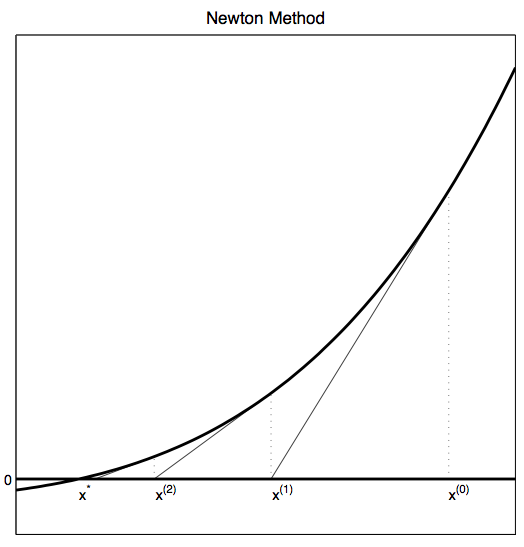

In [6]:
display.Image('graph_newton.png')

Comparing to simple function iteration above, we have one additional term, the derivative of $f$ at $x^{(k)}$. Hence, we use *more information on the properties of the function* than above. 

More precisely, we put a weight on the distance between the old guess $x^{(k)}$ and the new guess $x^{(k+1)}$. With function iteration, this weight was given by $f(x^{(k)})$, while in Newton's method, it is $f(x^{(k)})/f'(x^{(k)})$. 

It is intuitive why this is an improvement:
- if the absolute value of $f'(x^{(k)})$ is small, this means the function is relatively flat at $x^{(k)}$; in this case, it is likely that the current guess $x^{(k)}$ is still far from the root, and hence the jump to the next guess should be large
- if the absolute value of $f'(x^{(k)})$ is large, the function is relatively steep, making it more likely that we are close to  the root; hence the jump to the next guess should be small

##### Stopping Rules

In the algorithms seen so far, we have used two alternative stopping rules in the context of root finding: iteration stops if
-  the absolute value of $f(x)$ is close to 0, that is, less than the tolerance level: $|f(x)| < tol$ or
- the update to the current guess for $x$ is small, i.e. if $x^{(k+1)} = g(x^{(k)})$ is close to $x^{(k)}$, and hence $|x^{(k+1)} - x^{(k)}| < tol$.

For our purposes, either of them should work fine. Optionally, we can also combine them, e.g. use the second one as the stopping rule and then check if the function is close to zero at the final iterate (see below). 

This would be important in cases where convergence stops (and hence the change in $x^{(k)}$ would be less than *tol*) before a root is reached. 

A second point about stopping rules is that they should take into account the magnitude of the numbers involved. In the examples so far, we have dealt with small numbers. For a given tolerance level *tol*, how "close" two numbers are depend on their scale.

For example, suppose $tol = 1\text{e-8}$. If $x$ is of magnitude, say around 1, the algorithm stops when the first eight significant digits of $x^{(k+1)}$ and $x^{(k)}$ are the same.

In [7]:
tol = 1e-8
x1 = 1.0
x2 = 1.0 + tol
print(format(x1, '.20f'))
print(format(x2, '.20f'))

1.00000000000000000000
1.00000000999999993923


In contrast, if $x$ is of magnitude $1\text{e+10}$, the same tolerance level would imply that the first 18 digits must be the same for the algorithm to stop. Recall that with double precision, if the difference in magnitude of two numbers is less than machine epsilon - here $x$ and $tol$ - the computer cannot distinguish between $x$ and $x + tol$.

In other words, the stopping rule would effectively require $x^{(k+1)} = x^{(k)}$. This would be more accurate as in the first example, but also require the algorithm to run for longer. 

In [8]:
x1 = 1e+10
x2 = 1e+10 + tol
print(format(x1, '.20f'))
print(format(x2, '.20f'))

10000000000.00000000000000000000
10000000000.00000000000000000000


One way to deal with would be a *relative* stopping rule, i.e.

\begin{equation}
    \left|\frac{x^{(k+1)} - x^{(k)}}{x^{(k)}}\right| < tol\quad \Rightarrow \left|x^{(k+1)} - x^{(k)}\right| < tol \left| x^{(k)}\right|
\end{equation}    
    
Since this would cause problems if the root is close to zero, we add a "1" term:

\begin{equation}
    \left|x^{(k+1)} - x^{(k)}\right| < tol \left( 1 + \left| x^{(k)}\right|\right)
\end{equation}    
    

#### Pseudo-Code

Newton's method implements the following pseudo-code:

(i) Specify tolerance levels $tol1$ and $tol2$ and choose a starting guess $x^{(0)}$.

(ii) Compute the next iterate as 

\begin{equation}
 x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})}{f'(x^{(k)})}
\end{equation}

(iii) Check the stopping rule: if $|x^{(k+1)}- x^{(k)}| < tol1 (1 + |x^{(k)}|)$, stop. If not, go back to (ii).

(iv) If $|f(x^{(k+1)})| < tol2$, report $x^{(k+1)}$ as the solution. Otherwise, report failure. 

As outlined above, in step (iv), in contrast to the previous implementations of iterative method above, we include a check if the function gets close to zero once iteration has stopped.

The following code implements Newton's method. As before, the current guess for $x$ is printed in every iteration. 

Unsurprisingly given the intuition above, Newton's method needs considerably fewer iterations than simple function iteration.

In [9]:
## define functions
def fun(x):
    """
    Implements the example function 4*np.log(x) - 4
    """
    return 4*np.log(x) - 4


def fun_d(x):
    """
    Computes the derivative for the example function 4*np.log(x) - 4
    """
    return 4/x

def g_newton(fun, fun_d, x):
    """
    Implements the iteration rule for Newton's method. 
    """
    f, fd = fun(x), fun_d(x)
    return x - f * fd**(-1)

In [10]:
def my_newton(fun, fun_d, x, tol1 = 1e-8, tol2 = 1e-8):
    """
    Implements Newton's method. 
    """
    eps = 1
    it = 0
    
    while eps > tol1:
        it += 1
        x_new = g_newton(fun, fun_d, x)
        eps = abs(x - x_new)/(1 + abs(x))
        x = x_new
        print(x_new)
    
    print("Number of iterations = {}".format(it) )
    
    if abs(fun(x)) < tol2: 
        return x
    else:
        print("No solution found!")

In [11]:
x_root = my_newton(fun, fun_d, 1)

2.0
2.613705638880109
2.7162439263557903
2.718281064358138
2.7182818284589376
2.7182818284590455
Number of iterations = 6


The stopping criteria should not be set too loosely. For some functions, a higher $tol1$ does not impact the solution from Newton's method: 

In [12]:
x_root = my_newton(fun, fun_d, 1, tol1 = 1e-4)

2.0
2.613705638880109
2.7162439263557903
2.718281064358138
2.7182818284589376
Number of iterations = 5


For other functions, however, setting $tol1$ too high can result in finding a "root" quite far away from zero. This is true for functions that are quite flat around its root. For these functions, we also see very slow convergence. Note that in the example below, $f(x) = x^6$, a small $tol2$ does not compensate for a rather high $tol1$. 

In [13]:
def fun2(x):
    return x**6
def fd2(x):
    return 6 * x**(5)

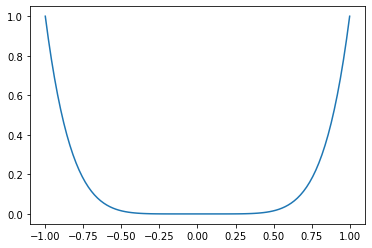

In [14]:
x = np.linspace(-1, 1, 100)
fig, ax = plt.subplots()
ax.plot(x, fun2(x))
# ax.plot(x, fd2(x))

In [15]:
x_root = my_newton(fun2, fd2, 1, tol1 = 1e-4, tol2 = 1e-10)
print(fun2(x_root))

0.8333333333333334
0.6944444444444444
0.5787037037037037
0.48225308641975306
0.4018775720164609
0.3348979766803841
0.2790816472336535
0.2325680393613779
0.19380669946781492
0.16150558288984576
0.13458798574153813
0.11215665478461512
0.09346387898717926
0.07788656582264938
0.06490547151887449
0.05408789293239541
0.04507324411032951
0.03756103675860792
0.031300863965506596
0.02608405330458883
0.021736711087157357
0.018113925905964463
0.015094938254970386
0.01257911521247532
0.010482596010396101
0.008735496675330084
0.00727958056277507
0.006066317135645892
0.00505526427970491
0.004212720233087425
0.0035106001942395207
0.002925500161866267
0.0024379168015552224
0.002031597334629352
0.0016929977788577933
0.0014108314823814943
0.0011756929019845785
0.0009797440849871487
0.0008164534041559572
0.0006803778367966309
0.0005669815306638591
0.00047248460888654926
Number of iterations = 42
1.1125665436700811e-20


#### Multivariate Case

The logic from the univariate case translates to a vector-valued function $\mathbf{f}: \mathbb{R}^n\ \rightarrow \mathbb{R}^n$.  Recall that its Jacobian is defined as:

\begin{equation}
 J(\mathbf{x}) = \left[
\begin{matrix}
 \partial f_1/ \partial x_1 & ... & \partial f_1/ \partial x_n \\
 \vdots & \ddots & \vdots \\
  \partial f_n/ \partial x_1 & ... & \partial f_n/ \partial x_n 
\end{matrix}  \right]
\end{equation}

Start with a first-order Taylor approximation around $\mathbf{x}_0$:

<a id='newt_mult'></a>
\begin{equation}
 0 = \mathbf{f}(\mathbf{x}) \approx \mathbf{f}(\mathbf{x}_0) + J(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0) \tag{1}
\end{equation}

As a side note, to see that a Taylor approximation works also in the case of vector-valued functions, note that we can apply it element-wise, i.e. 

\begin{equation}
 f_j(\mathbf{x}) \approx f_j(\mathbf{x}_0) + f_j(\mathbf{x})^T (\mathbf{x} - \mathbf{x}_0)
\end{equation}

and recall from above that

\begin{equation}
 J(\mathbf{x}) = \left[
\begin{matrix}
  \nabla f_1(\mathbf{x})^T \\
 \vdots  \\
  \nabla f_n(\mathbf{x})^T
\end{matrix}  \right]
\end{equation}

Hence,

\begin{equation}
 \mathbf{x} \approx \mathbf{x}_0 - J^{-1}(\mathbf{x}_0) \mathbf{f}(\mathbf{x}_0)
\end{equation}

The key idea is to use this relation iteratively, i.e. generate a sequence $\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, ..., \mathbf{x}^{(m)}$  where

\begin{equation}
 \mathbf{x}_{k+1} = \mathbf{x}_{k} - J^{-1}(\mathbf{x}_{k}) \mathbf{f}(\mathbf{x}_{k})
\end{equation}

As an example, consider the function

\begin{equation}
 \mathbf{f}(\mathbf{x}) = \left[
\begin{matrix}
 x_2^2 - 1 \\
  \sin{x_1} - x_2
\end{matrix}  \right]
\end{equation}

To apply Newton's method, start by coding up the function and its Jacobian:

In [16]:
def fun_vv(x):
    """
    Implements a system of equation in two unknowns, here f(x) = [x2**2 - 1; sin(x1) - x2]
    """
    return np.array( (x[1]**2 - 1 , np.sin(x[0]) - x[1] ) )

In [17]:
def fun_J(x):
    """
    Implements the Jacobian system of equation in two unknowns above
    """
    f_00 = 0
    f_01 = 2 * x[1]
    f_10 = np.cos(x[0])
    f_11 = -1
    
    return np.array([[f_00, f_01], [f_10, f_11]])   

In [18]:
def my_newton_mult(fun, fun_d, x,  tol = 1e-8):
    """
    Implements Newton's method for a vector-valued function
    """    
    eps = 1
    it = 0
    while eps > tol:
        it += 1
        f, J = fun(x), fun_d(x)
        x_new = x - np.linalg.inv(J) @ f
        eps = np.linalg.norm(x - x_new) / (1 + np.linalg.norm(x))
        x = x_new
    
    print("Number of iterations = {}".format(it) )
    
    return x

In [19]:
x_init = [1.5,0.9]
x = my_newton_mult(fun_vv, fun_J, x_init)
print(x)
print(fun_vv(x))

Number of iterations = 22
[1.57079635 1.        ]
[ 0.00000000e+00 -2.22044605e-16]


In [20]:
x_init = [3,-0.8]
x = my_newton_mult(fun_vv, fun_J, x_init)
print(x)
print(fun_vv(x))

Number of iterations = 25
[ 4.71238895 -1.        ]
[0.0000000e+00 4.4408921e-16]


As bisection, Newton's method is a local method, i.e. does not necessarily find all the roots. In the case of multiple solutions, like in the example above, it converges to one solution - which one depends on the starting point.

Moreover, it is not guaranteed that the iterates in Newton's method converge, in particular for "erratic" functions with high derivatives that change sign frequently. 

In such cases, Newton's method converges only for initial starting values that are sufficiently close to a root $\mathbf{x}^*$ (always assuming that the Jacobian $J$ is invertible and well-conditioned at  $\mathbf{x}^*$).

If $J$ is ill-conditioned at  $\mathbf{x}^*$, it can lead to inaccurately computed updates $\mathbf{x}^{(k)}$, which may prevent Newton's method from converging. 

As outlined in the last lecture, ill-conditioning can stem from units of measurement that vary vastly in their order of magnitude. Rescaling variables so that their values have comparable orders of magnitudes may be a remedy here (and is a good idea in general).

As a final remark, going back to equation [(1)](#newt_mult), a careful reader may have noticed that the task here is to solve a system of linear equations. Define $\mathbf{p^{(k)}} = \mathbf{x}^{(k+1)} - \mathbf{x}^{(k)}$ to see this:

\begin{equation}
 \mathbf{f}(\mathbf{x}^{(k)}) + J(\mathbf{x}^{(k)}) (\mathbf{x}^{(k+1)} - \mathbf{x}^{(k)}) = 0
\end{equation}

\begin{equation}
 J(\mathbf{x}^{(k)}) \mathbf{p^{(k)}} = -\mathbf{f}(\mathbf{x}^{(k)}) 
\end{equation}

That is, we solve a SLE for $\mathbf{p}^{(k)}$, the update step going from $\mathbf{x}^{(k)}$ to $\mathbf{x}^{(k+1)}$.

Hence, instead of using the inverse of $\mathbf{J}$ as above, we can modify our Newton algorithm to use the **linalg.solve** algorithm:

In [21]:
def my_newton_mult_v2(fun, fun_d, x,  tol = 1e-8):
    """
    Implements Newton's method for a vector-valued function using the linalg.solve algorithm
    """    
    eps = 1
    it = 0
    while eps > tol:
        it += 1
        f, J = fun(x), fun_d(x)
        p = np.linalg.solve(J, -f)
        eps = np.linalg.norm(p) / (1 + np.linalg.norm(x))
        x = x + p
    
    print("Number of iterations = {}".format(it) )
    
    return x

In [22]:
x_init = [1.5,0.9]
x = my_newton_mult_v2(fun_vv, fun_J, x_init)
print(x)
print(fun_vv(x))

Number of iterations = 22
[1.57079635 1.        ]
[ 0.00000000e+00 -2.22044605e-16]


--------------------------------------------------------------------------------------------------------------------------------
<a id = "numdiff"></a>

### Numerical Differentiation

Before moving on, it is useful to look at *numerical differentiation*: instead of working with precise derivatives of a function, we can use numerical approximations for these derivatives. 

This is very useful in particular when the function is complicated, and hence its precise derivatives are hard to obtain.  

Numerical derivatives are based on *finite differences*. In the one-dimensional case, we have 

\begin{equation}
    \frac{\partial f}{\partial x} \approx \frac{f(x + \epsilon) - f(x)}{\epsilon}
\end{equation}

where $\epsilon$ is small. In other words, the first derivative at $x$ is approximated by the response to a small perturbation of $x$. The approximation above is called the *forward-difference* or *one-sided-difference*. 

Note that finite differencing is a straightforward application of a first-order Taylor series (see above). In the one-dimensional case, we have

\begin{equation}
    f(x_0 + \epsilon) \approx f(x_0) + f'(x_0) \epsilon,
\end{equation}

which can be rearranged to give the forward-difference approximation above.

Similarly, the *central-difference* is given by:

\begin{equation}
    \frac{\partial f}{\partial x} \approx \frac{f(x + \epsilon)- f(x - \epsilon)}{2 \epsilon}
\end{equation}

What value should be chosen for $\epsilon$? A good rule of thumb is the square root of machine epsilon:

\begin{equation}
    \epsilon = \sqrt{\epsilon_{DP}} \approx 10^{-8}
\end{equation}

To get the numerical derivatives for a multivariate function $f: \mathbb{R}^n\ \rightarrow \mathbb{R}$ - i.e., an approximation to the gradient - start with first-order Taylor series around $f(\mathbf{x}_0 + \epsilon e_i)$, where $e_i$ is a canonical vector, with 1 in the $i$th position and 0 otherwise: 

\begin{equation}
    f(\mathbf{x}_0 + \epsilon e_i) \approx f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^{T} \epsilon e_i 
\end{equation}

Rearranging and omitting the subscripts gives the forward-difference formula as:

\begin{equation}
    \frac{\partial f(\mathbf{x})}{\partial x_{i}} = \nabla f(\mathbf{x})^{T} e_i \approx \frac{f(\mathbf{x} + \epsilon e_i) - f(\mathbf{x})}{\epsilon},
\end{equation}

#### Numerical Derivatives for Vector-Valued Functions

In the next section, we will need to use a numerical approximation to the Jacobian. To get there, first recall from above that for a multivariate function, a first-order Taylor approximation around $f(\mathbf{x}_0 + \epsilon \mathbf{p})$, for any arbitrary vector $\mathbf{p}$, is given by:

\begin{equation}
    f(\mathbf{x}_0 + \epsilon \mathbf{p}) \approx f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^{T} \epsilon \mathbf{p} 
\end{equation}

For a vector-valued function $\mathbf{f}: \mathbb{R}^n\ \rightarrow \mathbb{R}^n$, apply this Taylor approximation to every ``sub-function'' , i.e.

\begin{equation}
\mathbf{f}(\mathbf{x}_0 + \epsilon \mathbf{p}) = 
\left[
    \begin{array}{c}
        f_1(\mathbf{x}_0 + \epsilon \mathbf{p}) \\
        \vdots \\
        f_n(\mathbf{x}_0 + \epsilon \mathbf{p})
    \end{array} \right]
    \approx 
        \left[\begin{array}{c}
        f_1(\mathbf{x}_0) \\
        \vdots \\
        f_n(\mathbf{x}_0)
    \end{array}\right]
     + 
    \left[\begin{array}{c}
        \nabla f_1(\mathbf{x}_0)^{T} \\
        \vdots \\
        \nabla f_n(\mathbf{x}_0)^{T}
    \end{array} \right]
\epsilon \mathbf{p} 
\end{equation}


Recall from above that

\begin{equation}
 J(\mathbf{x}) = \left[
\begin{matrix}
  \nabla f_1(\mathbf{x})^T \\
 \vdots  \\
  \nabla f_n(\mathbf{x})^T
\end{matrix}  \right]
\end{equation}

and thus,

\begin{equation}
\mathbf{f}(\mathbf{x}_0 + \epsilon \mathbf{p})
    \approx \mathbf{f}(\mathbf{x}_0) + J(\mathbf{x}_0)\epsilon \mathbf{p} 
\end{equation}

Rearranging and omitting the subscripts, we get

\begin{equation}
     J(\mathbf{x}) \mathbf{p} \approx \frac{\mathbf{f}(\mathbf{x}+ \epsilon \mathbf{p}) - \mathbf{f}(\mathbf{x})}{\epsilon}
\end{equation}

Note that this expression does not give us an approximation for the full Jacobian, but rather for the product $J(\mathbf{x}) \mathbf{p}$. It requires two function evaluations.

Finally, note that a direct approximation of the complete Jacobian can be obtained by approximating the $i$th *column* of the Jacobian using

\begin{equation}
  J_i(\mathbf{x}) = \frac{\partial \mathbf{f}(\mathbf{x})}{\partial x_{i}}  \approx \frac{\mathbf{f}(\mathbf{x} + \epsilon e_i) - \mathbf{f}(\mathbf{x})}{\epsilon} 
\end{equation}

where $e_i$ is again the corresponding canonical vector. This would require $n + 1$ evaluations of the function $\mathbf{f}$, one for each column, plus one for $\mathbf{f}(\mathbf{x})$, which can amount to a considerable computational cost. 


#### In Python

Numerical differentation is helpful when using Newton's method, as outlined above. One common problem with Newton's method are programming errors when coding the Jacobian, in particular for complicated functions. An easy check is to compare the analytic Jacobian with its finite-difference counterpart. 

Python has a package **statsmodels** that includes a routine for numerical differentation of a vector-valued function, as illustrated by the following example. Note that this gives an approximation of the full Jacobian.

In [23]:
fun_J(x)

array([[ 0.00000000e+00,  2.00000000e+00],
       [-2.02764527e-08, -1.00000000e+00]])

In [24]:
import statsmodels.api as sm

sm.tools.numdiff.approx_fprime(x, fun_vv)

array([[ 0.00000000e+00,  2.00000001e+00],
       [-3.32023080e-08, -1.00000000e+00]])

As a side note, the SciPy package has a function of the same name, **scipy.optimize.approx_fprime**. In contrast to the **statsmodels** version, this works only for univariate and multivariate scalar functions; in the multivariate case, this computes the gradient. 

In [25]:
## precise derivative of the example function below
fun_d(3.5)

1.1428571428571428

In [26]:
## numerical derivative
import scipy.optimize
scipy.optimize.approx_fprime([3.5], fun, [1e-8])

array([1.1428571])

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'quasi'></a>

### Quasi-Newton Methods

There is an obvious cost of using Newton's method as outlined above: we need to provide the analytical derivative of a univariate scalar function or the Jacobian of a vector-valued function, respectively. 

While this may be not a big deal for simple functions as in the examples above, for more complicated problems, this step may involve a large cost in terms of time for computing the derivatives and for coding them up. 

Moreover, as mentioned above, coding up complicated derivatives increases the risk of programming errors.

Hence, in practice we often rely on "derivative-free" or *Quasi-Newton* methods. In a nutshell, their basic idea is the same as in Newton method's - successive linearization - but instead of using the precise derivatives of a function, we approximate them numerically. 

A drawback is that we have to provide an initial guess for the function's derivative or Jacobian.

#### Univariate Functions: Secant Method

In the one-dimensional case, an obvious idea would be to obtain the derivative in Newton's method by numerical differentation:

\begin{equation}
    f'(x^{(k)}) \approx \frac{f(x^{(k)} + \epsilon) - f(x^{(k)})}{\epsilon}
\end{equation}

While this would work, in practice we use the *secant method*, where the finite-difference approximation of $f'(x)$ is constructed from the function values at the current and the previous iterate:

\begin{equation}
    f'(x^{(k)}) \approx \frac{f(x^{(k)}) - f(x^{(k - 1)})}{x^{(k)} - x^{(k-1)}} \equiv (f')^{(k)}
\end{equation}

The main advantage is that this reduces the number of function evaluations: since $f(x^{(k - 1)})$ was evaluated anyway when updating the guess for $x$, it is easy to store and use for the update of $f'(x^{(k)})$. 

In the first expression, we would have to *additionally* evaluate $f(x^{(k)} + \epsilon)$ in every iteration. Note that the computational cost may not be large for simple function, but can be substantial for more complicated functions.

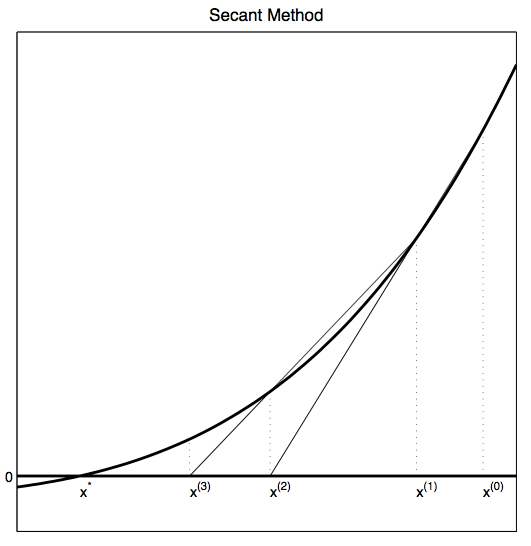

In [27]:
display.Image('graph_secant.png')

Note that the secant method generates not only a sequence $\left\{ x^{(k)} \right\}$, but also a sequence $\left\{(f')^{(k)} \right\}$ of approxiations of the derivative. 

In general, while $\left\{ x^{(k)} \right\}$ converge to the root of the function, $\left\{(f')^{(k)} \right\}$ does *not* converge to the derivative of $f$ at the root. 

In this week's problem set, you are asked to to implement this function numerically. Intuitively, the secant method requires more iterations and hence more function evaluations than Newton's method due to the approximation of the derivative. 

For more complex functions, however, this doesn't necessarily translate into a longer running time, as the secant method does not require to evaluate the function's derivative.

#### Vector-Valued Functions: Broyden's Method

The cost of computing exact analytical derivatives increases quadratically in the dimension of a vector-valued function. Hence, in practice, we usually rely on the multidimensional equivalent to the secant method, *Broyden's Method*.  

Recall that the iteration rule for Newton's method is given by 

\begin{equation}
 \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - J^{-1}(\mathbf{x}^{(k)}) \mathbf{f}(\mathbf{x}^{(k)})
\end{equation}

The idea of Broyden's method is to approximate $J(\mathbf{x}^{(k)})$ by a matrix $A^{(k)}$. Hence, we use the following iteration rule:

<a id = 'broyden'></a>
\begin{equation}
 \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \left(A^{(k)}\right)^{-1} \mathbf{f}(\mathbf{x}^{(k)}) \tag{2}
\end{equation}

As the superscript indicates, we will have to update $A^{(k)}$ in every iteration; in other words, we will get a sequence $\left\{A^{(k)}\right\}$. 

Assume we have determined $\mathbf{x}^{(k+1)}$ from $\mathbf{x}^{(k)}$ and $A^{(k)}$ using [(2)](#newton). How do we get $A^{(k+1)}$? One idea would be to use numerical differentiation to obtain $A^{(k+1)}$. 

We have already established above that approximating the Jacobian by itself would require $n + 1$ evaluations of the function $\mathbf{f}$, and hence be computationally demanding:

\begin{equation}
  J_i(\mathbf{x}^{(k+1)}) \approx \frac{\mathbf{f}(\mathbf{x}^{(k+1)} + \epsilon e_i) - \mathbf{f}(\mathbf{x}^{(k+1)})}{\epsilon}
\end{equation}


Instead, recall from above that for an arbitrary vector $\mathbf{p}$, we can approximate the product of the Jacobian of a vector-valued function and $\mathbf{p}$ by

\begin{equation}
     J(\mathbf{x}) \mathbf{p} \approx \frac{\mathbf{f}(\mathbf{x} + \epsilon \mathbf{p}) - \mathbf{f}(\mathbf{x})}{\epsilon}
\end{equation}

Analogous to the one-dimensional case, we will work with an approximation $A$ where $\epsilon = 1$. Setting $\mathbf{p}
^{(k)} = \mathbf{x}^{(k+1)} - \mathbf{x}^{(k)}$, define $A^{(k+1)}$ such that

\begin{equation}
 A^{(k+1)} \mathbf{p}^{(k)} = \mathbf{f}(\mathbf{x}^{(k+1)}) - \mathbf{f}(\mathbf{x}^{(k)}).
\end{equation}

That is, we require a numerical approximation $A^{(k+1)}$ of the Jacobian to satisfy the *secant condition*. In other words, $J(\mathbf{x}^{(k+1)})$ and its approximation $A^{(k+1)}$ have a similar behavior along the direction $\mathbf{p}^{(k)}$. 

However, note that there is no unique $A^{(k+1)}$ that satisfies the secant condition. In fact, the secant condition is a system of $n$ equations in $n^2$ unknowns, i.e. for $n^2$ elements of $A^{(k+1)}$. 

To solve this issue, Broyden's method gets $A^{(k+1)}$ by making the *smallest possible change* to $A^{(k)}$ (in the Frobenius norm), while requiring $A^{(k+1)}$ to satisfy the secant condition, i.e. 

\begin{equation}
 A^{(k+1)} \in \arg \min_{A :\ A \mathbf{p}^{(k)} = \mathbf{f}(\mathbf{x}^{(k+1)}) - \mathbf{f}(\mathbf{x}^{(k)})} || A - A^{(k)} ||_F
\end{equation}

It can be shown (cp. problem set 3, question A.1) that this is achieved by assuming that both $A^{(k+1)}$ and $A^{(k)}$ behave in the same way along directions *orthogonal to* $\mathbf{p}^{(k)}$, i.e. for any vector $\mathbf{q}$ where $\mathbf{q}^{T} \mathbf{p}^{(k)} = 0$.

In other words, for given $\mathbf{x}^{(k+1)}$, $\mathbf{x}^{(k)}$ and $A^{(k)}$, Broyden's method looks for an $A^{(k+1)}$ such that

\begin{equation}
 A^{(k+1)} \mathbf{p}^{(k)} = \mathbf{f}(\mathbf{x}^{(k+1)}) - \mathbf{f}(\mathbf{x}^{(k)}).
\end{equation}

and

\begin{equation}
 A^{(k+1)} \mathbf{q} = A^{(k)} \mathbf{q}\ \ \text{for}\ \ \mathbf{q}^{T} \mathbf{p}^{(k)} = 0
\end{equation}


You can show (cp. problem set 3, question A.1) that these requirements are satisfied by the following update rule for $A^{(k+1)}$:

\begin{equation}
 A^{(k+1)} = A^{(k)} + \frac{ \left( \mathbf{f}(\mathbf{x}^{(k+1)}) - \mathbf{f}(\mathbf{x}^{(k)}) - A^{(k)} \mathbf{p}^{(k)} \right) (\mathbf{p}^{(k)})^T}{(\mathbf{p}^{(k)})^T \mathbf{p}^{(k)}}
\end{equation}

Note that when implementing Broyden's method, it is computationally efficient to update the *inverse of* $A^{(k+1)}$ directly, rather than updating $A^{(k+1)}$ and then computing the inverse.

You can use the update rule on the previous slide to derive an update rule for $\left(A^{(k+1)}\right)^{-1}$ (which we will skip here). Since there are different ways to do this in practice, there are different variants of Broyden's method, in particular a "*good*" and a "*bad*" method. For this course, it will not matter which one you use. 

As a final remark, while we could write our implementation of Broyden's method, we will skip this and instead rely on Scipy's implementation, as outlined below.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'convergence'></a>

### Convergence

All of the methods above were iterative, i.e. generating sequences $x^{(k)}$ (hopefully) converging to the root of the function. Importanly, a sequence of iterates $x^{(k)}$ converges to $x^*$ at a rate of order $p$ if there is a constant $C$ such that

\begin{equation}
    || x^{(k+1)} - x^* || \le C || x^{(k)} - x^* ||^p
\end{equation}

for sufficiently large $k$. 

We can determine $C$ and $p$ for the different methods above:

- Bisection converges with $C = 0.5$ and $p = 1$, and hence at a *linear rate*

- Function iteration converges also at a linear rate, with $C$ equal to $f'(x^*)$


- The secant/Broyden's method converges at a *superlinear rate*, with $1 < p \approx 1.62 < 2$

- Newton's method converges at a *quadratic rate* of $p = 2$

Compare the example in M&F, section 3.6.

#### Summary: What method to pick?

- Newton's method has the fastest rate of convergence, but can require a lot of "developmental" effort; it should be used for nonlinear equations of small dimensions, when the derivatives are not too hard to find and to code, and when an equation is to be solved many times

- The secant/Broyden's method has a smaller rate of convergence (but still more than linear) and requires less programming time; it should be used when the derivatives are expensive to compute and code, and the equation is not solved too often

- In the univariate case, the bisection method is the most robust; for highly irregular functions, it can be used in combination with Newton's method, to find a close initial guess

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'scipy'></a>

### Root Finding in SciPy

Modern programming languages have built-in implementations of the algorithms outlined above. In Python, we mainly rely on the SciPy package, which comes with the Anaconda distribution. 

For rootfinding and numerical optimization (in the next lecture), we use Scipy's subpackage **scipy.optimize**, which we first need to import: 

In [28]:
import scipy.optimize

#### One dimension

For the univariate case, consider again the function 

\begin{equation}
    f(x) = 4 \ln(x) - 4
\end{equation}

We define the function and use the **bisect()** function, an implementation of the bisection method outlined above:

In [29]:
def fun(x):
    return 4*np.log(x) - 4

print(scipy.optimize.bisect(fun,1,4))

2.718281828459567


**bisect(fun,a,b)** takes three arguments: the function **fun** (which can be built-in or user-written), and an upper and lower initial guess for the root. In other words, you tell the algorithm to look for a root in the interval $[a,b]$. 

The important thing to remember here is that $f(a)$ and $f(b)$ must have different signs - if they do not, you will get an error message (in this case, change $a$ or $b$ and try again).  

In the example above, solving for the root using Python is not really necessary. The real advantage of numerical root finding is in situations where finding a solution to $f(x) = 0$ analytically is not feasible. Consider, for example,

\begin{equation}
    f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1
\end{equation}

We can Matplotlib to plot the function:

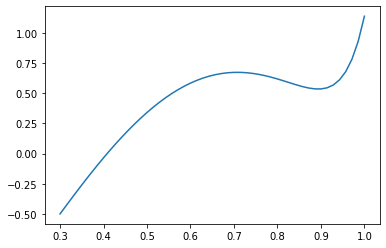

In [30]:
def fun(x):
    return np.sin(4 * (x - 0.25)) + x + x**20 - 1

fig, ax = plt.subplots()
x = np.linspace(0.3, 1, 50)
ax.plot(x, fun(x))

Finding a root via the bisection method is straightforward:

In [31]:
print(scipy.optimize.bisect(fun,0,2))

0.4082935042806639


The Scipy function **newton(fun, x, fprime = None)** implements both Newton's method (if the derivate of the function is given as **fprime**)  and the secant method for univariate rootfinding.

In [32]:
def fun_d(x):
    return np.cos(4 * (x - 0.25)) * 4 + 1 + 20 * x**19

scipy.optimize.newton(fun,0.6, fun_d)

0.408293504279367

In [33]:
scipy.optimize.newton(fun,0.6)

0.40829350427936667

We can use Jupyter's **%timeit** magic to compare the running time of each of the three methods:

In [34]:
%timeit -n1 scipy.optimize.bisect(fun,0,2)

114 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit -n1 scipy.optimize.newton(fun,0.6)

396 µs ± 96.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%timeit -n1 scipy.optimize.newton(fun,0.6, fun_d)

309 µs ± 43.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


For comparison, our implementation of Newton's method above takes about the same running time.

In [37]:
def my_newton(fun, fun_d, x, tol1 = 1e-8, tol2 = 1e-8):
    
    eps = 1
    it = 0
    maxit = 100
    
    while eps > tol1 and it < maxit:
        it += 1
        x_new = g_newton(fun, fun_d, x)
        eps = abs(x - x_new) / abs(x)
        x = x_new
    
    if abs(fun(x)) < tol2: 
        return x
    else:
        print("No solution found!")


In [38]:
my_newton(fun, fun_d, 0.99)

0.40829350427936706

In [39]:
%timeit -n1 my_newton(fun, fun_d, 0.6)

69.4 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multiple Dimensions: NGM Revisited

As an example for a multidimensional system of nonlinear equation, let's go back to our NGM model. Recall that a steady state is given by $(k_s, h_s)$ such that

\begin{equation}
    \left[
    \begin{array}{c}
        S_1 \\
        S_2
    \end{array}
    \right] =    
    \left[
    \begin{array}{c}
        \beta \left[f_k(k_s, h_s) + 1 - \delta \right]  - 1 \\
        \left[ f(k_s, h_s) - \delta k \right]^{-\nu} f_h(k_s, h_s) - B h_s^{\eta}
    \end{array}
    \right] = 
    \left[
    \begin{array}{c}
        0 \\
        0
    \end{array}
    \right]
\end{equation}

To solve this system numerically, we first need to assign values to the model parameters. 

##### Parameters

In [40]:
## utility
beta = 0.9     # discount factor
nu = 2         # risk-aversion coefficient for consumption
eta = 1        # elasticity parameter for labor supply

## production
alpha = 0.25   # income share capital
delta = 0.1    # depreciation rate

For productivity $A$ and the disutility weight $B$, we choose values such that the steady state values for $k_s$ and $h_s$ normalize to 1.  

Recall that the Euler Equation evaluated at the steady state reads:
\begin{equation}
    1 = \beta \left[A \alpha k_s^{\alpha-1} h_s^{1 - \alpha} + 1 - \delta \right]    
\end{equation}

Setting $k_s = 1$ and $h_s = 1$ and rearranging, we get
\begin{equation}
    A  =  \frac{1 - \beta (1 - \delta)}{\alpha \beta }
\end{equation}


The intratemporal optimality condition evaluated at the steady state is

\begin{equation}
    B h_s^{\eta} = \left[ A k_s^{\alpha} h_s^{1 - \alpha} - \delta k_s \right]^{-\nu} A (1-\alpha) k_s^{\alpha} h_s^{ - \alpha} 
\end{equation}

Setting $k_s = 1$ and $h_s = 1$ and rearranging, we get
\begin{equation}
    B = \left[ A - \delta \right]^{-\nu} A (1-\alpha) 
\end{equation}


In [41]:
## derived
A = (1 - beta * (1 - delta))/(alpha*beta)  # productivity
B = (1 - alpha) * A * (A - delta)**(-nu)      # parameter for utility function

##### Functions

Next, it will be useful to define some auxiliary functions that implement the Cobb-Douglas production function, as well as its first and second derivatives.

In [42]:
def cobb_douglas_v1(x, alpha, A):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x[0]**alpha * x[1]**(1 - alpha)

x = np.array([2,0.5])
print(cobb_douglas_v1(x, alpha, A))

0.5971123930019733


Note that we have written the function such that the Cobb-Douglas parameters **alpha** and **A** are explicit arguments of **cobb_douglas_v1**. While this works fine, it can become a bit tedious to explicitly keep track of parameters in this way, in particular for functions that have a lot of them.

At first glance, a better alternative might be to not include the parameters as function inputs:

In [43]:
def cobb_douglas_v2(x):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x[0]**alpha * x[1]**(1 - alpha)

x = np.array([2,0.5])
print(cobb_douglas_v2(x))

0.5971123930019733


This works because we have defined **alpha** and **A** before. In Python terms, these variables are part of the **global** namespace:

In [44]:
%whos

Variable            Type           Data/Info
--------------------------------------------
A                   float          0.8444444444444442
B                   float          1.142793495210515
alpha               float          0.25
ax                  AxesSubplot    AxesSubplot(0.125,0.125;0.775x0.755)
beta                float          0.9
cobb_douglas_v1     function       <function cobb_douglas_v1 at 0x000002CCFA440438>
cobb_douglas_v2     function       <function cobb_douglas_v2 at 0x000002CCFA4408B8>
datetime            module         <module 'datetime' from '<...>\\cme\\lib\\datetime.py'>
delta               float          0.1
display             module         <module 'IPython.display'<...>es\\IPython\\display.py'>
eta                 int            1
fd2                 function       <function fd2 at 0x000002CCF3B301F8>
fig                 Figure         Figure(432x288)
fun                 function       <function fun at 0x000002CCFA397B88>
fun2                function   

When the function is called, Python encounters **alpha** and **A**; since they are not explicit arguments of the function, Python checks whether they are variables in the global namespace, and uses the values stored there.

As a side note, in the previous version, **cobb_douglas_v1**, where **alpha** and **A** were arguments to the function, they were part of the function's *local* namespace. 

In other words, the **alpha** that you see used in the body of **cobb_douglas_v1** and the **alpha** in the global namespace *refer to two different objects*!

Going back to **cobb_douglas_v2**, working with parameters as *global variables* seems like a convenient option. However, it is not encouraged and often considered "bad practice" (QuantEcon: *"global variables are dangerous"*).

In particular, suppose you change parameters at different points in your program, for example to conduct comparative statics. It can become quite hard to keep track of their current values, in particular with a lot of different parameters. This is exacerbated by the property that global variables can be changed (often accidentally) by any function.

For more background, see http://wiki.c2.com/?GlobalVariablesAreBad

A better alternative here is to define parameters in a dictionary, and then use this dictionary as an input into the function. In this way, we can keep track of the current parameter values, without having to provide individual parameter values every time we call the function. 

In [45]:
prm = {'beta': beta,
         'nu': nu,
         'eta': eta,         
         'B': B,
         'delta': delta,
         'alpha': alpha,
         'A': A
        }

As an additional advantage, it becomes clear which variables are parameters and which are not when writing the function.

In [46]:
def cobb_douglas(x, prm):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return prm['A'] * x[0]**prm['alpha'] * x[1]**(1 - prm['alpha'])

x = np.array([2,0.5])
print(cobb_douglas(x, prm))

0.5971123930019733


Next, we define functions to compute the first and second derivatives of the CD production function:

In [47]:
def cd_diff(x, prm):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return (prm['alpha'] * cobb_douglas(x, prm) / x[0], 
            (1 - prm['alpha']) * cobb_douglas(x, prm) / x[1])

def cd_diff2(x, prm):
    """
    Evaluates the second derivative (returned as a tuple, with the cross derivative as the last element) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return (prm['alpha'] * (prm['alpha'] - 1) * cobb_douglas(x, prm) / x[0]**2, 
            (1 - prm['alpha']) * (-prm['alpha']) * cobb_douglas(x, prm) / x[1]**2,
            prm['alpha'] * (1 - prm['alpha']) * cobb_douglas(x, prm) / (x[0] * x[1]) )

Finally, we can code up the system of nonlinear equations $S$ as a Numpy array.


In [48]:
def steady(x, prm):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(2)
    mp = cd_diff(x, prm)
    
    y[0] = prm['beta'] * (mp[0] + 1 - prm['delta']) - 1
    y[1] = (cobb_douglas(x, prm) - prm['delta'] * x[0])**(-prm['nu']) * mp[1] - prm['B'] * x[1]**prm['eta']
    
    return y

For Newton's method, we also need to provide the Jacobian, i.e.

\begin{equation}
 J(k, h) = \left[
\begin{matrix}
 \partial S_1/ \partial k &  \partial S_1/ \partial h \\
  \partial S_2/ \partial k &  \partial S_2 / \partial h 
\end{matrix}  \right]
\end{equation}

In [49]:
def steady_jac(x, prm):
    """
    Returns the Jacobian of the vector-valued function consisting of the steady-state conditions 
    """
    J = np.zeros((2,2))
    mp = cd_diff(x, prm)
    mp2 = cd_diff2(x, prm)
    
    Q = cobb_douglas(x, prm) - prm['delta'] * x[0]
    
    J[0,0] = prm['beta'] * mp2[0] 
    J[0,1] = prm['beta'] * mp2[2]
    J[1,1] = -prm['nu'] * Q**(-prm['nu']-1) * mp[1]**2 + Q**(-prm['nu']) * mp2[1] \
                            - prm['B'] * prm['eta'] * x[1]**(prm['eta'] - 1)
    J[1,0] = -prm['nu'] * Q**(-prm['nu']-1) * mp[1] * (mp[0] - prm['delta']) + Q**(-prm['nu']) * mp2[2] 
    
    return J

To solve for the steady state, we first use our implementation of Newton's method written above. We have to slightly modify it by adding the parameter dictionary as an additional input.

In [50]:
def my_newton_ngm(fun, fun_d, x, prm, tol = 1e-8):
    """
    Implements Newton's method for a vector-valued function
    """    
    eps = 1
    it = 0
    while eps > tol:
        it += 1
        f, J = fun(x, prm), fun_d(x, prm)
        x_new = x - np.linalg.inv(J) @ f
        eps = np.linalg.norm(x - x_new) / (1 + np.linalg.norm(x))
        x = x_new
    
    print("Number of iterations = {}".format(it) )
    
    return x

In [51]:
x0 = np.array([0.5, 0.5])
my_newton_ngm(steady, steady_jac, x0, prm)

Number of iterations = 6


array([1., 1.])

Next, we use Scipy's implementation of Broyden's (good) method outlined above. For this, we call Scipy's **optimize.root** function, which is essentially a "wrapper" around different algorithms for solving nonlinear systems of equations, not only Broyden's method. Apart from the solution vector, it also provides information on function values, number of iterations and whether or not the algorithm has converged to a solution.

As Broyden's method is derivative-free, we do not have to provide the Jacobian here. 

In [52]:
res = scipy.optimize.root(steady, x0, args = (prm), tol = 1e-8, method = "broyden1")
print(res)

     fun: array([-7.02771175e-14,  6.86117829e-14])
 message: 'A solution was found at the specified tolerance.'
     nit: 25
  status: 1
 success: True
       x: array([1., 1.])


As expected, Broyden's method takes more iterations to solve the system than Newton's method.

Note that the **args** keyword inside the call of **optimize.root** is used to provide additional arguments of the input function (here **steady**) apart from the solution vector **x**.

Finally, we can also use Broyden's "bad" method (**broyden2**), which should give the same result:

In [53]:
res = scipy.optimize.root(steady, x0, args = (prm), tol = 1e-8, method = "broyden2")
print(res)

     fun: array([1.43143275e-11, 4.77706763e-12])
 message: 'A solution was found at the specified tolerance.'
     nit: 13
  status: 1
 success: True
       x: array([1., 1.])


-------------------------------------------------------------------------------------------------------------------------------
<a id = 'funiter'></a>

## Appendix

### Function Iteration

Recall that the basic idea of iterative methods is to generate a sequence of approximations to the object of interest, e.g. the solution to linear or nonlinear system of equations, following an iteration rule: 

\begin{equation}
    x^{(k+1)} = g( x^{(k)} ),
\end{equation}

where $k$ is an indicator counting the number of iterations. 

When finding the root of a function $f$ or solving for a system of nonlinear equations with function iteration, the functional form of $g$ is simply

\begin{equation}
    g( x ) = x - f(x).
\end{equation}

This is intuitive: at the root $ x = x^* $, we have $f(x^*) = 0$ and hence $g (x^*) = x^*$. In other words, $x^*$ is a *fixed point*.

The following piece of code implements function iteration. As a simple workhorse example, consider the function

\begin{equation}
    f(x) = 4 \ln(x) - 4,
\end{equation}

which has a root at $x = e^1 = 2.718282$. 

In [54]:
## define functions
def fun(x):
    return 4*np.log(x) - 4

def g(x):
    return x - fun(x)

Before running the algorithm, we have to provide a starting value ("initial guess") for $x$.

Moreover, we also have to choose a tolerance level **tol** for the stopping rule. As for the stopping rule itself, we terminate the algorithm if $x^{(k+1)} = g(x^{(k)})$ is close to $x^{(k)}$.

In [55]:
## initial guess for x
x = 4
## tolerance level for stopping rule
tol = 1e-8
## for illustration: iteration counter and list to store results
it = 0
lst = []

For illustration, we print the current guess for $x^{(k)}$ for each iteration. As we can see,  $x^{(k)}$ converges to $x^*$ as the number of iterations increases.

In [56]:
while abs((x - g(x))) > tol: 
    it += 1
    ## apply g function and store and print results
    x = g(x)  
    lst.append(x)
    print(x)
    

print("Number of iterations = {}".format(it) )

2.4548225555204377
2.862604636225108
2.6556769468169183
2.748878575829132
2.70410642422237
2.725020362315921
2.7151167603287156
2.7197769279002424
2.717577467326751
2.718614081555206
2.7181251950992964
2.7183556905115984
2.7182470026657746
2.7182982497675234
2.7182740855933667
2.7182854793739897
2.7182801069913993
2.718282640162424
2.718281445726661
2.718282008924203
2.718281743366526
2.718281868581682
2.71828180954051
2.718281837379471
2.718281824252906
Number of iterations = 25


We can Python's matplotlib package to illustrate how function iteration works.

Text(0, 0.5, '$g(x)$')

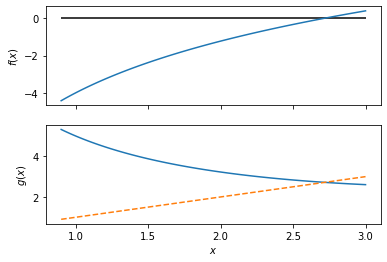

In [57]:
x = np.linspace(0.9, 3, 100)
fig, ax = plt.subplots(2,1, sharex = True)
# ax[0].ylabel($$f(x)$$)
ax[0].plot(x, fun(x))
ax[0].hlines(0, 0.9, 3)
ax[1].plot(x, g(x))
ax[1].plot(x, x, '--')
ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$f(x)$')
ax[1].set_ylabel('$g(x)$')

-------------------------------------------------------------------------------------------------------------------------------
### Backstepping

We can modify Newton's algorithm as outlined above to increase the likelihood of convergence, by incorporating *backstepping*. 

Intuitively, if the sequence of iterates $\mathbf{x}^{(k)}$ "goes in the wrong direction" - that is, if the distance to the root gets larger instead of smaller as $k$ increases - we decrease the size of the "step" to the next iterate.

In more detail, denote $dx$ as the update to the current guess $\mathbf{x}^{(k)}$ that would follow from applying Newton's rule:

\begin{equation}
 dx = \mathbf{x}^{(k+1)}-\mathbf{x}^{(k)} = - J^{-1}(\mathbf{x}^{(k)}) \mathbf{f}(\mathbf{x}^{(k)})
\end{equation}

We compare the norm of $f(\mathbf{x}^{(k)} + dx)$ with the norm of $f(\mathbf{x}^{(k)})$ to see if it became smaller, i.e. moved the function closer to its root (where $f(\mathbf{x}^{*}) = 0 $). 

Consider two cases:

(i) If $|| f(\mathbf{x}^{(k)} + dx) || < || f(\mathbf{x}^{(k)})||$, the iterates go in the right direction, and we can update $\mathbf{x}^{(k+1)}$ as before:

\begin{equation}
 \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + dx
\end{equation}


(ii) If $|| f(\mathbf{x}^{(k)}) + dx || > || f(\mathbf{x}^{(k)})||$, the update step goes in the "wrong" direction, and hence we need to decrease the step size, for example to $0.5 dx$. Then,

   - if $|| f(\mathbf{x}^{(k)} + \frac{dx}{2}) || < || f(\mathbf{x}^{(k)} + dx)||$, use $0.5 dx$ as the new step size, and go back to (i).

   - if $|| f(\mathbf{x}^{(k)} + \frac{dx}{2}) || > || f(\mathbf{x}^{(k)} + dx)||$, backstepping does not lead to an improvement. Hence, we terminate backstepping and continue Newton's method with $dx$.